# Prep

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd drive/MyDrive/sp/data
! ls

/content/drive/MyDrive/sp/data
deep_set_bc.pth    KaggleDataset_withBO.txt  PL_scraped_ord.csv
FakeData_EPL.csv   old_FakeData_EPL.csv      team_bc.pth
KaggleDataset.csv  player_bc.pth	     wl.pth


In [3]:
! pip install torchinfo
import torchinfo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn import Embedding,\
                     Module,\
                     Linear,\
                     Dropout,\
                     Tanh,\
                     ReLU,\
                     BatchNorm1d,\
                     LogSoftmax,\
                     NLLLoss,\
                     Conv1d,\
                     ModuleList
import torch.nn.functional as F

# Dataset

In [4]:
dataset = pd.read_csv('KaggleDataset_withBO.txt')
dataset.tail(3)

,match_id,country,league,season,week,date,home_team,away_team,home_goal,away_goal,...,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA
19524,24495,Spain,Spain LIGA BBVA,2015/2016,38,2016-05-15 00:00:00,Málaga CF,UD Las Palmas,4,1,...,4.5,1.83,3.70,4.00,1.85,3.45,4.0,1.80,3.60,4.33
19525,24496,Spain,Spain LIGA BBVA,2015/2016,38,2016-05-14 00:00:00,Atlético Madrid,RC Celta de Vigo,2,0,...,4.5,1.83,3.60,4.10,1.85,3.70,3.7,1.83,3.60,4.20
19526,24497,Spain,Spain LIGA BBVA,2015/2016,38,2016-05-15 00:00:00,Rayo Vallecano,Levante UD,3,1,...,9.0,1.33,4.75,9.25,1.40,5.00,6.0,1.33,5.25,9.00


# Dataset Transform

## Label Setting

In [5]:
teams = np.unique(dataset[['away_team', 'home_team']].values)
team_lblenc = LabelEncoder()
team_lblenc.fit(teams)

players = np.unique(
    np.concatenate(
      (
        np.stack(dataset['home_lineup'].apply(lambda lineup: lineup.split(' - '))).reshape(-1),
        np.stack(dataset['away_lineup'].apply(lambda lineup: lineup.split(' - '))).reshape(-1)
      )    
    )
)
player_lblenc = LabelEncoder()
player_lblenc.fit(players)

results = pd.unique(dataset['result'])
result_lblenc = LabelEncoder()
result_lblenc.fit(results)

LabelEncoder()

## Labeling

In [6]:
home_team_labels = team_lblenc.transform(dataset['home_team'])
away_team_labels = team_lblenc.transform(dataset['away_team'])

home_player_labels = player_lblenc.transform(
     np.stack(dataset['home_lineup'].apply(lambda lineup: lineup.split(' - '))).reshape(-1)
).reshape(-1, 11)
away_player_labels = player_lblenc.transform(
     np.stack(dataset['away_lineup'].apply(lambda lineup: lineup.split(' - '))).reshape(-1)
).reshape(-1, 11)

result_labels = result_lblenc.transform(dataset['result'])



In [7]:
str_home_players = np.char.mod('%d', home_player_labels)
str_home_player_labels = np.apply_along_axis(lambda arr: ' - '.join(arr), axis=1, arr=str_home_players)

str_away_players = np.char.mod('%d', away_player_labels)
str_away_player_labels = np.apply_along_axis(lambda arr: ' - '.join(arr), axis=1, arr=str_away_players)

## Creating dataset

In [8]:
meta_dict = {
        'home_team_label': home_team_labels,
        'away_team_label': away_team_labels,
        'result_label': result_labels,
        'home_lineup_label': str_home_player_labels,
        'away_lineup_label': str_away_player_labels,
}

for column in dataset.columns:
  meta_dict.update({column: dataset[column].values})

transformed_dataset = pd.DataFrame(
    meta_dict
)

In [9]:
transformed_dataset.head()

,home_team_label,away_team_label,result_label,home_lineup_label,away_lineup_label,match_id,country,league,season,week,...,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA
0,120,116,2,9306 - 4986 - 6709 - 6262 - 4819 - 5142 - 4320...,2135 - 4335 - 2309 - 2051 - 679 - 8929 - 1874 ...,146,Belgium,Belgium Jupiler League,2008/2009,24,...,2.30,2.95,3.25,2.20,2.80,3.1,2.2,2.75,3.25,2.20
1,117,45,0,1161 - 2200 - 730 - 3114 - 9195 - 8770 - 8323 ...,8645 - 6361 - 747 - 4241 - 9052 - 5108 - 4903 ...,154,Belgium,Belgium Jupiler League,2008/2009,25,...,2.37,3.10,3.00,2.20,2.80,3.1,2.2,3.20,3.20,2.00
2,173,203,2,2140 - 7005 - 835 - 5777 - 7839 - 4021 - 5468 ...,8097 - 4902 - 8643 - 956 - 4228 - 5515 - 5041 ...,156,Belgium,Belgium Jupiler League,2008/2009,25,...,8.00,1.35,4.00,9.00,1.35,4.0,7.0,1.36,4.00,7.00
3,120,173,2,9306 - 4986 - 6709 - 9310 - 5109 - 4819 - 6262...,2140 - 7005 - 7839 - 6758 - 9109 - 4021 - 4515...,163,Belgium,Belgium Jupiler League,2008/2009,26,...,1.75,4.70,3.30,1.70,4.20,3.2,1.7,4.00,3.40,1.72
4,203,118,1,8097 - 4902 - 8580 - 8643 - 956 - 5515 - 5041 ...,4858 - 1796 - 6579 - 4218 - 740 - 859 - 8489 -...,169,Belgium,Belgium Jupiler League,2008/2009,26,...,4.75,1.60,3.55,5.05,1.65,3.4,4.2,1.61,3.25,5.00


# Dataset Split

In [10]:
info = """
Belgium Jupiler League
	 903
	 139
	 139
England Premier League
	 2354
	 294
	 306
France Ligue 1
	 2290
	 284
	 281
Germany 1. Bundesliga
	 1876
	 240
	 252
Italy Serie A
	 2161
	 269
	 274
Netherlands Eredivisie
	 1601
	 209
	 209
Portugal Liga ZON Sagres
	 907
	 153
	 170
Scotland Premier League
	 1214
	 157
	 158
Spain LIGA BBVA
	 2123
	 276
	 288
"""
leagues = []
splits = []
for i in info.split('\n'):
  j = i.strip()
  if any([c.isalpha() for c in j]):
    leagues.append(j)
  elif j:
    splits.append(j)

leagues = np.array(leagues).tolist()
sizes = np.array(splits).reshape(-1, 3).astype(np.int16).tolist()
splits = dict(zip(leagues, sizes))
splits

{'Belgium Jupiler League': [903, 139, 139],
 'England Premier League': [2354, 294, 306],
 'France Ligue 1': [2290, 284, 281],
 'Germany 1. Bundesliga': [1876, 240, 252],
 'Italy Serie A': [2161, 269, 274],
 'Netherlands Eredivisie': [1601, 209, 209],
 'Portugal Liga ZON Sagres': [907, 153, 170],
 'Scotland Premier League': [1214, 157, 158],
 'Spain LIGA BBVA': [2123, 276, 288]}

In [11]:
train_groups = []
dev_groups = []
test_groups = []
# batch_size = 64
for league, data in transformed_dataset.groupby('league'):
  # split_size = int(data.shape[0] * 0.63 // batch_size * batch_size)
  # split_size = int(data.shape[0] * 0.64)
  split_size = splits[league][0]
  train_set, dev_test = train_test_split(data, shuffle=False, stratify=None, train_size=split_size)
  split_size = splits[league][1]
  dev_set, test_set = train_test_split(dev_test, shuffle=False, stratify=None, train_size=split_size)

  print(league)
  print('Train Dev Test')
  print(train_set.shape[0], dev_set.shape[0], test_set.shape[0])
  print(f'{train_set.shape[0] / data.shape[0] * 100:.2f}%, {dev_set.shape[0] / data.shape[0] * 100:.2f}%, {test_set.shape[0] / data.shape[0] * 100:.2f}%')
  print('-' * 24)

  train_groups.append(train_set)
  dev_groups.append(dev_set)
  test_groups.append(test_set)

Belgium Jupiler League
Train Dev Test
903 139 139
76.46%, 11.77%, 11.77%
------------------------
England Premier League
Train Dev Test
2354 294 306
79.69%, 9.95%, 10.36%
------------------------
France Ligue 1
Train Dev Test
2290 284 281
80.21%, 9.95%, 9.84%
------------------------
Germany 1. Bundesliga
Train Dev Test
1876 240 252
79.22%, 10.14%, 10.64%
------------------------
Italy Serie A
Train Dev Test
2161 269 274
79.92%, 9.95%, 10.13%
------------------------
Netherlands Eredivisie
Train Dev Test
1601 209 209
79.30%, 10.35%, 10.35%
------------------------
Portugal Liga ZON Sagres
Train Dev Test
907 153 170
73.74%, 12.44%, 13.82%
------------------------
Scotland Premier League
Train Dev Test
1214 157 158
79.40%, 10.27%, 10.33%
------------------------
Spain LIGA BBVA
Train Dev Test
2123 276 288
79.01%, 10.27%, 10.72%
------------------------


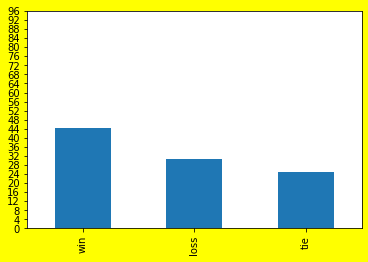

In [12]:
train_data = pd.concat(train_groups).sort_values(by='date').reset_index(drop=True)
dev_data = pd.concat(dev_groups).sort_values(by='date').reset_index(drop=True)
test_data = pd.concat(test_groups).sort_values(by='date').reset_index(drop=True)
ax = test_data['result'].value_counts().div(test_data.shape[0]).div(0.01).plot.bar(yticks=np.arange(100, step=4))
ax.get_figure().set_facecolor('yellow')

In [13]:
dataset.query('result == "tie"').shape[0] * 100 / dataset.shape[0] 

25.24197265324935

# Optimization and Evaluation Algorithms

## Training

In [14]:
def train(model, optimizer, home, away, y, loss_fn):
  model.train()
  optimizer.zero_grad()

  output = model(home, away) # forward prop
  loss = loss_fn(output, y) # loss
  loss.backward() # backprop
  optimizer.step() # parameter updating

  return loss.item()

## Evaluating

In [15]:
@torch.no_grad()
def evaluate(model, home, away, y):
  model.eval()

  output = model(home, away)
  prediction = output.argmax(-1)

  correct = (prediction == y).sum()

  return correct.item(), y.shape[0]

In [16]:
@torch.no_grad()
def rps(model, home, away, y):
  model.eval()
  prediction = torch.exp(model(home, away))
  labels = F.one_hot(y, 3)
  return (((torch.cumsum(prediction, -1) - torch.cumsum(labels, -1)) ** 2).sum(1) / 2).mean().item()


## Gradient Descent Fitting

In [17]:
def fit(model, train_set, batch_size, dev_set, optimizer, loss_fn, num_epochs, every=100):
  # assert train_set[0].shape[-1] == train_set[1].shape[-1]
  # assert dev_set[0].shape[-1] == dev_set[1].shape[-1]
  try:
    train_accs = []
    dev_accs = []
    
    train_home, train_away, train_y = train_set
    train_home_batches = torch.split(train_home, batch_size)
    
    train_away_batches = torch.split(train_away, batch_size)
    train_y_batches = torch.split(train_y, batch_size)

    dev_home, dev_away, dev_y = dev_set

    print('Initial State')
    train_correct, train_all = 0, 0
    for home, away, y in zip(train_home_batches, train_away_batches, train_y_batches):
      train_c, train_a = evaluate(
          model, 
          home, 
          away, 
          y
      )
      train_correct += train_c
      train_all += train_a

    dev_correct, dev_all = evaluate(model, dev_home, dev_away, dev_y)
    train_accs.append(train_correct / train_all * 100) 
    dev_accs.append(dev_correct / dev_all * 100)
    print(f'Train Acc%: {train_correct / train_all * 100:.4f}')
    print(f'Dev   Acc%: {dev_correct / dev_all * 100:.4f}')

    for epoch in range(1, num_epochs + 1):
      
      epoch_loss = 0
      train_correct, train_all = 0, 0
      for home_batch, away_batch, y_batch in zip(train_home_batches, train_away_batches, train_y_batches):
        if home_batch.shape[0] == 1:
          continue
        batch_loss = train(model, optimizer, home_batch, away_batch, y_batch, loss_fn)
        epoch_loss += batch_loss
        train_c, train_a = evaluate(
          model, 
          home_batch, 
          away_batch, 
          y_batch
        )
        train_correct += train_c
        train_all += train_a
      dev_correct, dev_all = evaluate(model, dev_home, dev_away, dev_y)
      train_accs.append(train_correct / train_all * 100) 
      dev_accs.append(dev_correct / dev_all * 100)
      if epoch % every == 0:
        print('-' * 60)
        print(f'Epoch {epoch}')
        print(f'Avg Train Loss: {epoch_loss / train_home.shape[0]:.4f}')
        print(f'Train Acc%:     {train_correct / train_all * 100:.4f}')
        print(f'Dev   Acc%:     {dev_correct / dev_all * 100:.4f}')
  except KeyboardInterrupt:
    pass
  finally:
    return train_accs, dev_accs

## Main

In [18]:
def main(train_group, batch_size, dev_group, test_group, model, optimizer, loss_fn, n_epochs, every, league=None):
  try:
    (home_train, away_train, y_train) = train_group
    (home_dev, away_dev, y_dev) = dev_group
    (home_test, away_test, y_test) = test_group
    if league:
      print(f'Fitting on the {league} for {n_epochs} epochs')
      print('.' * 60)
    train_accs, dev_accs = fit(
      model, 
      (home_train, away_train, y_train),
      batch_size,
      (home_dev, away_dev, y_dev),
      optimizer,
      loss_fn,
      n_epochs,
      every
    )
    
  except KeyboardInterrupt:
      pass
  finally:
    test_correct, test_all = evaluate(model, home_test, away_test, y_test.reshape(-1))
    print(f'Test Acc%: {test_correct / test_all * 100:.4f}')
    print('=' * 60)

    return train_accs, dev_accs, test_correct / test_all * 100


# Blade Chest Model

In [19]:
class BladeChest(Module):
  def __init__(self, feature_size, blade_chest_size, dropout_p=0.5):
    super(BladeChest, self).__init__()
    self.feature_size = feature_size
    self.blade_chest_size = blade_chest_size
    self.dropout_p = dropout_p
    self.chest_transform = Linear(self.feature_size, self.blade_chest_size, bias=False)
    self.chest_bn = BatchNorm1d(self.blade_chest_size)

    self.blade_transform = Linear(self.feature_size, self.blade_chest_size, bias=False)
    self.blade_bn = BatchNorm1d(self.blade_chest_size)

    self.regularizer = Dropout(p=self.dropout_p)
    self.activation = Tanh()

    self.result_transform = Linear(1, 3)
    self.classifier = LogSoftmax(dim=-1)

  def _encode_team(self, team):
    blade = self.blade_transform(team)
    blade = self.blade_bn(blade)
    blade = self.activation(blade)
    blade = self.regularizer(blade)

    chest = self.chest_transform(team)
    chest = self.chest_bn(chest)
    chest = self.activation(chest)
    chest = self.regularizer(chest)

    return blade, chest


  def _matchup(self, home_blade, home_chest, away_blade, away_chest):
    return (home_blade * away_chest).sum(-1) - (away_blade * home_chest).sum(-1)

  def forward(self, home, away):
    home_blade, home_chest = self._encode_team(home)
    away_blade, away_chest = self._encode_team(away)

    matchup_score = self._matchup(home_blade, home_chest, away_blade, away_chest).reshape(-1, 1)

    result = self.result_transform(matchup_score)
    result = self.classifier(result)
    result = self.regularizer(result)

    return result

# Cat Feed Forward Model

In [ ]:
class CatFeedForward(Module):
  def __init__(self, feature_size, hidden_sizes, dropout_p=0.5):
    super(CatFeedForward, self).__init__()
    self.feature_size = feature_size
    self.hidden_sizes = hidden_sizes
    self.dropout_p = dropout_p

    layers_list = [feature_size * 2] + self.hidden_sizes + [3]

    self.fc_layers = ModuleList(
        [
         Linear(size, layers_list[index + 1])
         for index, size in enumerate(layers_list[:-1])
        ]
    )

    self.bn_layers = ModuleList(
        [
         BatchNorm1d(size)
         for size in layers_list[1:-1]
        ]
    )

    self.regularizer = Dropout(p=self.dropout_p)
    self.activation = ReLU()

    self.classifier = LogSoftmax(dim=-1)

  def forward(self, home, away):
    h = torch.cat((home, away), dim=-1)
    for fc, bn in zip(self.fc_layers[:-1], self.bn_layers):
      h = fc(h)
      h = bn(h)
      h = self.activation(h)
      h = self.regularizer(h)
      
    result = self.fc_layers[-1](h)
    result = self.classifier(result)
    result = self.regularizer(result)

    return result

# Team Blade Chest Modeling

## TeamBladeChest Model 

In [20]:
class TeamBladeChest(Module):
  def __init__(self, num_teams, embedding_size, blade_chest_size, dropout=0.5):
    super(TeamBladeChest, self).__init__()
    self.num_teams = num_teams
    self.embedding_size = embedding_size
    self.blade_chest_size = blade_chest_size
    self.dropout=dropout
    self.team_embedder = Embedding(self.num_teams, self.embedding_size)
    self.emb_bn = BatchNorm1d(self.embedding_size)
    self.decoder = BladeChest(self.embedding_size, self.blade_chest_size, dropout)
    self.regularizer = Dropout(p=self.dropout)

  def _encode_team(self, team):
    embedding = self.team_embedder(team)
    embedding = self.emb_bn(embedding)
    #dropout here?
    emnedding = self.regularizer(embedding)
    return embedding

  def forward(self, home, away):
    home_encoded = self._encode_team(home)
    # home_encoded = F.one_hot(home, self.num_teams).double()
    away_encoded = self._encode_team(away)
    # away_encoded = F.one_hot(away, self.num_teams).double()
    return self.decoder(home_encoded, away_encoded)

## Hyperparameters

In [21]:
home = torch.from_numpy(transformed_dataset.loc[:, ['home_team_label']].values.reshape(-1))
away = torch.from_numpy(transformed_dataset.loc[:, ['away_team_label']].values.reshape(-1))
y = torch.from_numpy(transformed_dataset.loc[:, ['result_label']].values.reshape(-1))

assert home.max() == away.max()
num_teams = home.max() + 1
embedding_size = 4
hidden_size = 8
batch_size = 32
learning_rate = 1e-3
n_epochs = 250
every = 25

tbc_model = TeamBladeChest(
    num_teams,
    embedding_size,
    hidden_size,
    dropout=0.5
).double()

optimizer = torch.optim.Adam(tbc_model.parameters(), lr=learning_rate)
criterion = NLLLoss()
tbc_model

TeamBladeChest(
  (team_embedder): Embedding(254, 4)
  (emb_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder): BladeChest(
    (chest_transform): Linear(in_features=4, out_features=8, bias=False)
    (chest_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blade_transform): Linear(in_features=4, out_features=8, bias=False)
    (blade_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (regularizer): Dropout(p=0.5, inplace=False)
    (activation): Tanh()
    (result_transform): Linear(in_features=1, out_features=3, bias=True)
    (classifier): LogSoftmax(dim=-1)
  )
  (regularizer): Dropout(p=0.5, inplace=False)
)

## Fitting league-separate

In [ ]:
league_train_accs = []
league_dev_accs = []
league_test_accs = []
for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(train_set.loc[:, ['home_team_label']].values.reshape(-1))
  # home_train = torch.split(home_train, batch_size)
  away_train = torch.from_numpy(train_set.loc[:, ['away_team_label']].values.reshape(-1))
  # away_train = torch.split(away_train, batch_size)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))
  # y_train = torch.split(y_train, batch_size)

  home_dev = torch.from_numpy(dev_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_dev = torch.from_numpy(dev_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(test_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_test = torch.from_numpy(test_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  train_accs, dev_accs, test_acc = main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      tbc_model, 
      optimizer,
       criterion,
       n_epochs=80,
       every=16,
      league=np.unique(train_set["league"].values).item(),
  )
  league_train_accs.append(train_accs)
  league_dev_accs.append(dev_accs)
  league_test_accs.append(test_acc)
  

Fitting on the Belgium Jupiler League for 80 epochs
............................................................
Initial State
Train Acc%: 33.2226
Dev   Acc%: 36.6906
------------------------------------------------------------
Epoch 16
Avg Train Loss: 0.0410
Train Acc%:     45.8472
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 32
Avg Train Loss: 0.0357
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 48
Avg Train Loss: 0.0360
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 64
Avg Train Loss: 0.0347
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 80
Avg Train Loss: 0.0343
Train Acc%:     46.1794
Dev   Acc%:     49.6403
Test Acc%: 46.0432
Fitting on the England Premier League for 80 epochs
.........................................................

### With RPS per league

In [ ]:
league_train_accs = []
league_dev_accs = []
league_test_accs = []
league_rps = []
for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(train_set.loc[:, ['home_team_label']].values.reshape(-1))
  # home_train = torch.split(home_train, batch_size)
  away_train = torch.from_numpy(train_set.loc[:, ['away_team_label']].values.reshape(-1))
  # away_train = torch.split(away_train, batch_size)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))
  # y_train = torch.split(y_train, batch_size)

  home_dev = torch.from_numpy(dev_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_dev = torch.from_numpy(dev_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(test_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_test = torch.from_numpy(test_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  train_accs, dev_accs, test_acc = main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      tbc_model, 
      optimizer,
       criterion,
       n_epochs=80,
       every=16,
      league=np.unique(train_set["league"].values).item(),
  )
  league_train_accs.append(train_accs)
  league_dev_accs.append(dev_accs)
  league_test_accs.append(test_acc)
  league_rps.append( rps(tbc_model, home_test, away_test, y_test) )

Fitting on the Belgium Jupiler League for 80 epochs
............................................................
Initial State
Train Acc%: 25.0277
Dev   Acc%: 23.0216
------------------------------------------------------------
Epoch 16
Avg Train Loss: 0.0409
Train Acc%:     25.5814
Dev   Acc%:     23.7410
------------------------------------------------------------
Epoch 32
Avg Train Loss: 0.0360
Train Acc%:     46.2901
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 48
Avg Train Loss: 0.0339
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 64
Avg Train Loss: 0.0340
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 80
Avg Train Loss: 0.0348
Train Acc%:     46.1794
Dev   Acc%:     49.6403
Test Acc%: 46.0432
Fitting on the England Premier League for 80 epochs
.........................................................

## Plots

In [ ]:
import matplotlib.pyplot as plt

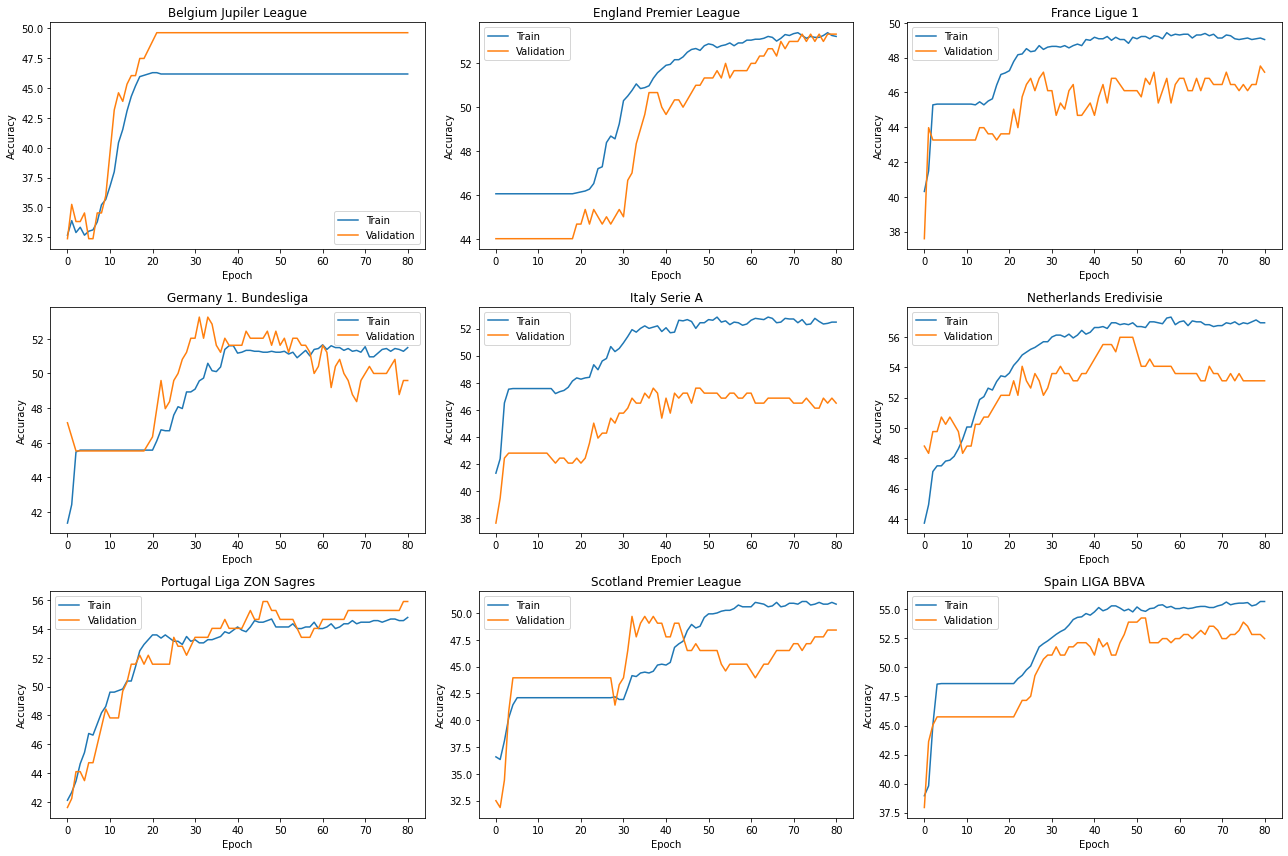

In [ ]:
fig, axs = plt.subplots(3, 3)
for train_acc, dev_acc, league_data, ax in zip(league_train_accs, league_dev_accs, train_groups, axs.reshape(-1)):
  league = league_data['league'].values[0]
  y_train = np.array(train_acc)
  y_dev = np.array(dev_acc)
  x = np.arange(0, len(y_train))
  ax.plot(x, y_train)
  ax.plot(x, y_dev)
  ax.legend(['Train', 'Validation'])
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title(league)
plt.gcf().set_size_inches(18, 12)
plt.gcf().set_facecolor('w')
fig.tight_layout()
plt.show()

## Accuracy

In [ ]:
size = 0
sum = 0
bahrami = dict()
leagues = []
for league_data, test_acc in zip(test_groups, league_test_accs):
  sample_size = league_data.shape[0]

  league = league_data['league'].values[0]
  leagues.append(league)
  sum += (sample_size * test_acc)
  size += sample_size
  bahrami.update({league: (sample_size, size)})
  print(league)
  print(f'Test Acc: {test_acc:.2f}% ')
  print('-' * 32)
print(f'Overall Test Acc: {sum / size:.2f}% ')

Belgium Jupiler League
Test Acc: 46.04% 
--------------------------------
England Premier League
Test Acc: 43.14% 
--------------------------------
France Ligue 1
Test Acc: 49.82% 
--------------------------------
Germany 1. Bundesliga
Test Acc: 50.79% 
--------------------------------
Italy Serie A
Test Acc: 46.72% 
--------------------------------
Netherlands Eredivisie
Test Acc: 51.20% 
--------------------------------
Portugal Liga ZON Sagres
Test Acc: 52.35% 
--------------------------------
Scotland Premier League
Test Acc: 44.94% 
--------------------------------
Spain LIGA BBVA
Test Acc: 55.90% 
--------------------------------
Overall Test Acc: 49.11% 


In [ ]:
size = 0
sum = 0
bahrami = dict()
leagues = []
sum_rps = 0
acc = dict()
rpss = dict()
for league_data, test_acc, rps in zip(test_groups, league_test_accs, league_rps):
  sample_size = league_data.shape[0]

  league = league_data['league'].values[0]
  acc.update({league: test_acc})
  rpss.update({league: rps})
  leagues.append(league)
  sum += (sample_size * test_acc)
  sum_rps += (sample_size * rps)
  size += sample_size
  bahrami.update({league: (sample_size, size)})
  print(league)
  print(f'Test Acc: {test_acc:.2f}% ')
  print('-' * 32)
print(f'Overall Test Acc: {sum / size:.2f}% ')
print(f'Overall RPS: {sum_rps / size:.3f}')
print(acc, rpss)

Belgium Jupiler League
Test Acc: 46.04% 
--------------------------------
England Premier League
Test Acc: 40.52% 
--------------------------------
France Ligue 1
Test Acc: 48.04% 
--------------------------------
Germany 1. Bundesliga
Test Acc: 48.81% 
--------------------------------
Italy Serie A
Test Acc: 49.64% 
--------------------------------
Netherlands Eredivisie
Test Acc: 54.07% 
--------------------------------
Portugal Liga ZON Sagres
Test Acc: 51.76% 
--------------------------------
Scotland Premier League
Test Acc: 47.47% 
--------------------------------
Spain LIGA BBVA
Test Acc: 56.60% 
--------------------------------
Overall Test Acc: 49.16% 
Overall RPS: 0.213
{'Belgium Jupiler League': 46.043165467625904, 'England Premier League': 40.52287581699346, 'France Ligue 1': 48.04270462633452, 'Germany 1. Bundesliga': 48.80952380952381, 'Italy Serie A': 49.63503649635037, 'Netherlands Eredivisie': 54.066985645933016, 'Portugal Liga ZON Sagres': 51.76470588235295, 'Scotland

In [ ]:
dict(zip(leagues, league_test_accs))

{'Belgium Jupiler League': 46.043165467625904,
 'England Premier League': 43.13725490196079,
 'France Ligue 1': 49.8220640569395,
 'Germany 1. Bundesliga': 50.79365079365079,
 'Italy Serie A': 46.715328467153284,
 'Netherlands Eredivisie': 51.196172248803826,
 'Portugal Liga ZON Sagres': 52.352941176470594,
 'Scotland Premier League': 44.936708860759495,
 'Spain LIGA BBVA': 55.90277777777778}

## RPS

In [ ]:
# tbc_model.load_state_dict(torch.load('team_bc.pth'))
tbc_model.eval()
rps_by_leagues = dict()
total_size = 0
total_r = 0
for test_set in test_groups:
  league_name = test_set['league'].values[0]
  size = test_set.shape[0]
  total_size += size
  home_test = torch.from_numpy(test_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_test = torch.from_numpy(test_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))
  league_rps = round(rps(tbc_model, home_test, away_test, y_test), 4)
  total_r += league_rps * size
  rps_by_leagues.update({league_name: league_rps})
print(rps_by_leagues)
print(total_r / total_size)

## Fitting whole-leagues

In [ ]:
# batch_size = train_set.shape[0]
home_train = torch.from_numpy(train_data.loc[:, ['home_team_label']].values.reshape(-1))
# home_train = torch.split(home_train, batch_size)
away_train = torch.from_numpy(train_data.loc[:, ['away_team_label']].values.reshape(-1))
# away_train = torch.split(away_train, batch_size)
y_train = torch.from_numpy(train_data.loc[:, ['result_label']].values.reshape(-1))
# y_train = torch.split(y_train, batch_size)

home_dev = torch.from_numpy(dev_data.loc[:, ['home_team_label']].values.reshape(-1))
away_dev = torch.from_numpy(dev_data.loc[:, ['away_team_label']].values.reshape(-1))
y_dev = torch.from_numpy(dev_data.loc[:, ['result_label']].values.reshape(-1))

home_test = torch.from_numpy(test_data.loc[:, ['home_team_label']].values.reshape(-1))
away_test = torch.from_numpy(test_data.loc[:, ['away_team_label']].values.reshape(-1))
y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

train_acc, val_accs, test_acc = main(
    (home_train, away_train, y_train),
      batch_size,
    (home_dev, away_dev, y_dev),
    (home_test, away_test, y_test),
    tbc_model, 
    optimizer,
      criterion,
      n_epochs=100,
      every=25    
)

## Analysis

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Model Vectors

In [ ]:
tbc_model.eval()
english_teams = transformed_dataset.query('league == "England Premier League"')['home_team'].unique()
english_team_labels = team_lblenc.transform(english_teams)
name_labels = dict(zip(english_teams, english_team_labels))
h = torch.from_numpy(english_team_labels)
embeddings = tbc_model._encode_team(h)
# embeddings = F.one_hot(h, tbc_model.num_teams).double()
blade, chest = tbc_model.decoder._encode_team(embeddings)


### t-SNE

In [ ]:
blade_1_dim = TSNE(
    n_components=1, 
     learning_rate='auto', 
     init='random'
).fit_transform(blade.detach().numpy())

chest_1_dim = TSNE(
    n_components=1, 
     learning_rate='auto', 
     init='random'
).fit_transform(chest.detach().numpy())

blade_2_dim = TSNE(
    n_components=2, 
     learning_rate='auto', 
     init='random'
).fit_transform(blade.detach().numpy())

chest_2_dim = TSNE(
    n_components=2, 
     learning_rate='auto', 
     init='random'
).fit_transform(chest.detach().numpy())

hidden_2_dim = TSNE(
    n_components=2, 
     learning_rate='auto', 
     init='random'
).fit_transform(embeddings.detach().numpy())

### 2 dim Blade and Chest

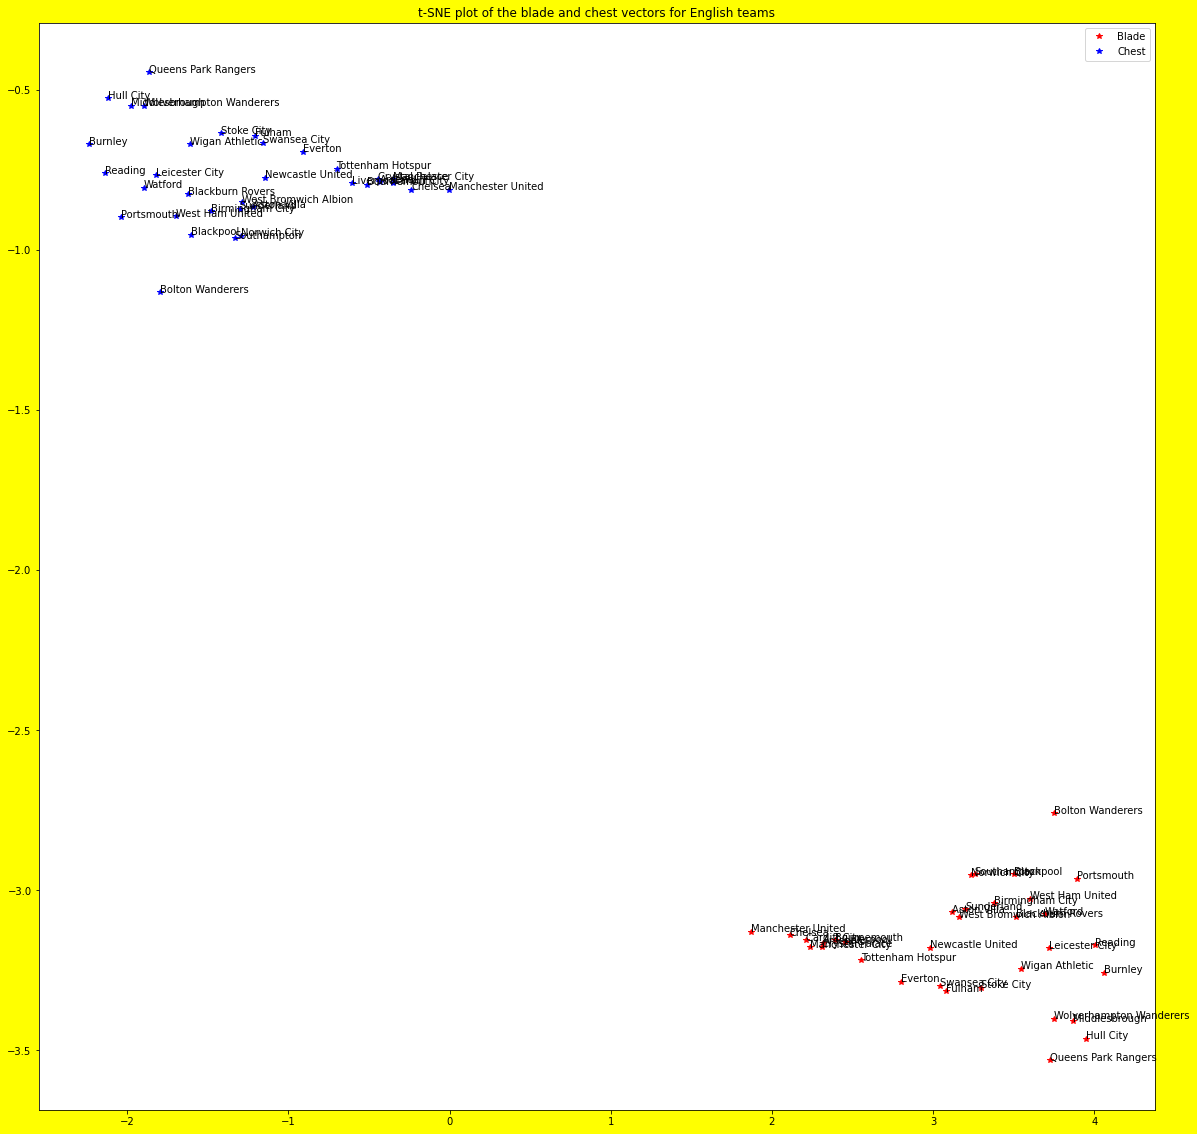

In [ ]:
X_blade, Y_blade = blade_2_dim[:, 0], blade_2_dim[:, 1]
X_chest, Y_chest = chest_2_dim[:, 0], chest_2_dim[:, 1]
plt.plot(X_blade, Y_blade, 'r*')
plt.plot(X_chest, Y_chest, 'b*')
fig = plt.gcf()
fig.set_facecolor('yellow')
fig.set_size_inches(20, 20)
plt.title('t-SNE plot of the blade and chest vectors for English teams')
plt.legend(['Blade', 'Chest'])
for x_blade, y_blade, x_chest, y_chest, team in zip(X_blade, Y_blade, X_chest, Y_chest, english_teams):
  # l = team.split(' ')
  # if len(l) > 1:
  #   label = f'{l[0]} {l[1][:3]}.'
  # else:
  #   label = l[0]
  label = team
  plt.annotate(label, (x_blade, y_blade))
  plt.annotate(label, (x_chest, y_chest))


### 1 dim Chest v Blade

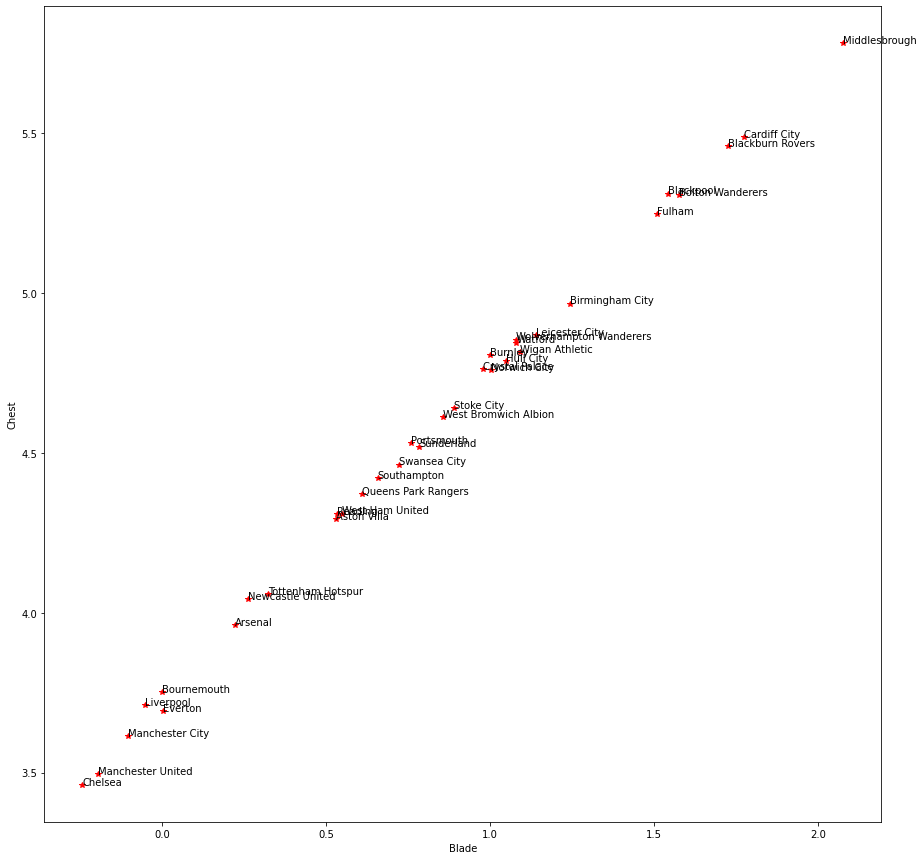

In [ ]:
plt.plot(blade_1_dim, chest_1_dim, 'r*')
fig = plt.gcf()
fig.set_facecolor('w')
fig.set_size_inches(15, 15)
# plt.title('t-SNE plot of the blade and chest vectors for English teams')
plt.xlabel('Blade')
plt.ylabel('Chest')
for x_blade, y_chest, team in zip(blade_1_dim, chest_1_dim, english_teams):
  # l = team.split(' ')
  # if len(l) > 1:
  #   label = f'{l[0]} {l[1][:3]}.'
  # else:
  #   label = l[0]
  label = team
  plt.annotate(label, (x_blade, y_chest))

### 2 dim Hidden feature vectors

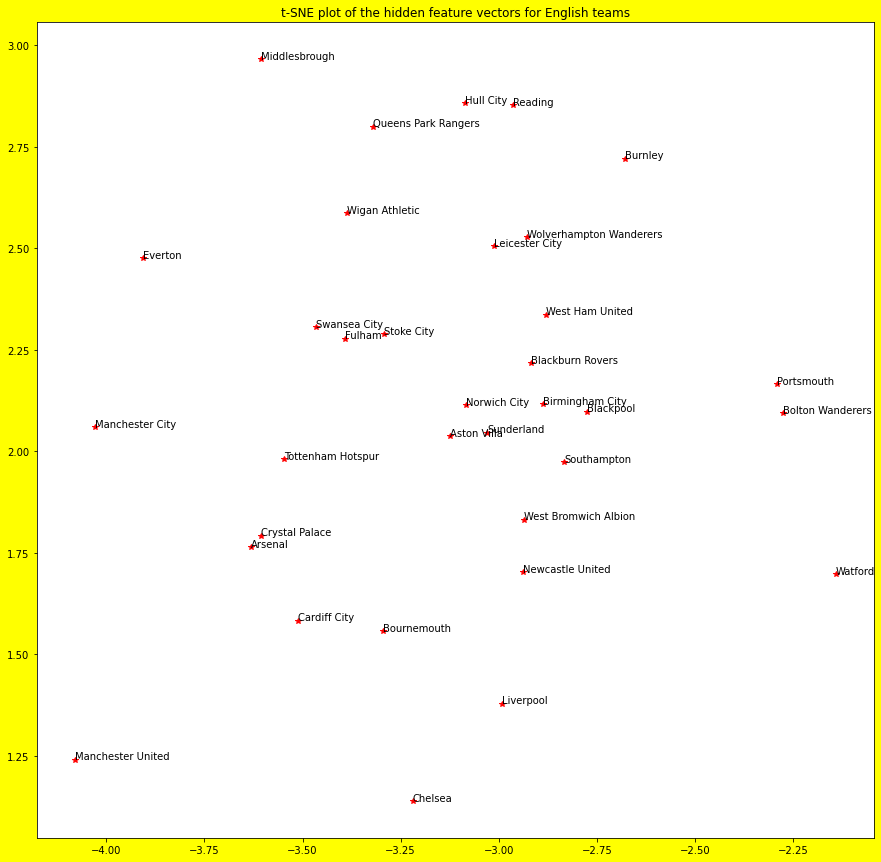

In [ ]:
X, Y = hidden_2_dim[:, 0], hidden_2_dim[:, 1]
plt.plot(X, Y, 'r*')
fig = plt.gcf()
fig.set_facecolor('yellow')
fig.set_size_inches(15, 15)
plt.title('t-SNE plot of the hidden feature vectors for English teams')
for x, y, team in zip(X, Y, english_teams):
  # l = team.split(' ')
  # if len(l) > 1:
  #   label = f'{l[0]} {l[1][:3]}.'
  # else:
  #   label = l[0]
  label = team
  plt.annotate(label, (x, y))

# Team Cat Feed Forward Modeling

## TeamCatFeedForward Model 

In [ ]:
class TeamCatFeedForward(Module):
  def __init__(self, num_teams, embedding_size, feed_forward_sizes, dropout=0.5):
    super(TeamCatFeedForward, self).__init__()
    self.num_teams = num_teams
    self.embedding_size = embedding_size
    self.feed_forward_sizes = feed_forward_sizes
    self.dropout=dropout
    self.team_embedder = Embedding(self.num_teams, self.embedding_size)
    self.emb_bn = BatchNorm1d(self.embedding_size)
    self.decoder = CatFeedForward(self.embedding_size, self.feed_forward_sizes)
    self.regularizer = Dropout(p=self.dropout)

  def _encode_team(self, team):
    embedding = self.team_embedder(team)
    embedding = self.emb_bn(embedding)
    #dropout here?
    emnedding = self.regularizer(embedding)
    return embedding

  def forward(self, home, away):
    home_encoded = self._encode_team(home)
    away_encoded = self._encode_team(away)
    return self.decoder(home_encoded, away_encoded)

## Hyperparameters

In [ ]:
home = torch.from_numpy(transformed_dataset.loc[:, ['home_team_label']].values.reshape(-1))
away = torch.from_numpy(transformed_dataset.loc[:, ['away_team_label']].values.reshape(-1))
y = torch.from_numpy(transformed_dataset.loc[:, ['result_label']].values.reshape(-1))

assert home.max() == away.max()
num_teams = home.max() + 1
embedding_size = 4
hidden_sizes = [8]
batch_size = 32
learning_rate = 1e-3
n_epochs = 250
every = 25

tcff_model = TeamCatFeedForward(
    num_teams,
    embedding_size,
    hidden_sizes,
    dropout=0.5
)

optimizer = torch.optim.Adam(tcff_model.parameters(), lr=learning_rate)
criterion = NLLLoss()
tcff_model

TeamCatFeedForward(
  (team_embedder): Embedding(254, 4)
  (emb_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder): CatFeedForward(
    (fc_layers): ModuleList(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): Linear(in_features=8, out_features=3, bias=True)
    )
    (bn_layers): ModuleList(
      (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (regularizer): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (classifier): LogSoftmax(dim=-1)
  )
  (regularizer): Dropout(p=0.5, inplace=False)
)

## Fitting league-separate

In [ ]:
for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(train_set.loc[:, ['home_team_label']].values.reshape(-1))
  # home_train = torch.split(home_train, batch_size)
  away_train = torch.from_numpy(train_set.loc[:, ['away_team_label']].values.reshape(-1))
  # away_train = torch.split(away_train, batch_size)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))
  # y_train = torch.split(y_train, batch_size)

  home_dev = torch.from_numpy(dev_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_dev = torch.from_numpy(dev_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(test_set.loc[:, ['home_team_label']].values.reshape(-1))
  away_test = torch.from_numpy(test_set.loc[:, ['away_team_label']].values.reshape(-1))
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      np.unique(train_set["league"].values).item(),
      tcff_model, 
      optimizer,
       criterion,
       n_epochs,
       every    
  )

Fitting on the Belgium Jupiler League for 250 epochs
............................................................
Initial State
Train Acc%: 43.4921
Dev   Acc%: 43.2727
------------------------------------------------------------
Epoch 25
Avg Train Loss: 0.0338
Train Acc%:     49.3651
Dev   Acc%:     41.8182
------------------------------------------------------------
Epoch 50
Avg Train Loss: 0.0332
Train Acc%:     51.5873
Dev   Acc%:     42.9091
------------------------------------------------------------
Epoch 75
Avg Train Loss: 0.0333
Train Acc%:     51.1111
Dev   Acc%:     43.2727
------------------------------------------------------------
Epoch 100
Avg Train Loss: 0.0338
Train Acc%:     52.0635
Dev   Acc%:     42.9091
------------------------------------------------------------
Epoch 125
Avg Train Loss: 0.0311
Train Acc%:     52.2222
Dev   Acc%:     43.6364
------------------------------------------------------------
Epoch 150
Avg Train Loss: 0.0315
Train Acc%:     52.3810
Dev   A

## Fitting whole-leagues

In [ ]:

# batch_size = train_set.shape[0]
home_train = torch.from_numpy(train_data.loc[:, ['home_team_label']].values.reshape(-1))
# home_train = torch.split(home_train, batch_size)
away_train = torch.from_numpy(train_data.loc[:, ['away_team_label']].values.reshape(-1))
# away_train = torch.split(away_train, batch_size)
y_train = torch.from_numpy(train_data.loc[:, ['result_label']].values.reshape(-1))
# y_train = torch.split(y_train, batch_size)

home_dev = torch.from_numpy(dev_data.loc[:, ['home_team_label']].values.reshape(-1))
away_dev = torch.from_numpy(dev_data.loc[:, ['away_team_label']].values.reshape(-1))
y_dev = torch.from_numpy(dev_data.loc[:, ['result_label']].values.reshape(-1))

home_test = torch.from_numpy(test_data.loc[:, ['home_team_label']].values.reshape(-1))
away_test = torch.from_numpy(test_data.loc[:, ['away_team_label']].values.reshape(-1))
y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

main(
    (home_train, away_train, y_train),
      batch_size,
    (home_dev, away_dev, y_dev),
    (home_test, away_test, y_test),
    tcff_model, 
    optimizer,
      criterion,
      n_epochs,
      every    
)

Initial State
Train Acc%: 28.5714
Dev   Acc%: 44.8041
------------------------------------------------------------
Epoch 25
Avg Train Loss: 0.0321
Train Acc%:     49.7655
Dev   Acc%:     46.9944
------------------------------------------------------------
Epoch 50
Avg Train Loss: 0.0316
Train Acc%:     52.9859
Dev   Acc%:     49.0144
------------------------------------------------------------
Epoch 75
Avg Train Loss: 0.0310
Train Acc%:     53.2160
Dev   Acc%:     49.5984
------------------------------------------------------------
Epoch 100
Avg Train Loss: 0.0307
Train Acc%:     53.5433
Dev   Acc%:     49.4037
------------------------------------------------------------
Epoch 125
Avg Train Loss: 0.0307
Train Acc%:     53.6141
Dev   Acc%:     49.2577
Test Acc%: 49.4037


# Player Blade Chest Modeling

## PlayerOneHot Model

In [22]:
class PlayerOneHot(Module):
  def __init__(self, num_players):
    super(PlayerOneHot, self).__init__()
    self.num_players = num_players

  def forward(self, players):
    return F.one_hot(players, self.num_players).sum(-2).double()

## PlayerBladeChest Model

In [23]:
class PlayerBladeChest(Module):
  def __init__(self, num_players, blade_chest_size, dropout_p=0.5):
    super(PlayerBladeChest, self).__init__()
    self.num_players = num_players
    self.blade_chest_size = blade_chest_size
    self.dropout_p = dropout_p
    self.one_hot = PlayerOneHot(self.num_players)
    self.decoder = BladeChest(self.num_players, self.blade_chest_size, dropout_p)

  def forward(self, home, away):
    home_encoded = self.one_hot(home)
    away_encoded = self.one_hot(away) 

    return self.decoder(home_encoded, away_encoded)

## Hyperparameters

In [24]:
home_players = torch.from_numpy(home_player_labels)
away_players = torch.from_numpy(away_player_labels)
assert home_players.max() == away_players.max()
num_players = home_players.max() + 1

# embedding_size = 5
hidden_size = 1
learning_rate = 1e-3
n_epochs = 27
every = 3
batch_size = 32

pbc_model = PlayerBladeChest(
    num_players,
    hidden_size,
    dropout_p=0.5
).double()

optimizer = torch.optim.Adam(pbc_model.parameters(), lr=learning_rate)
criterion = NLLLoss()
print(pbc_model)
torchinfo.summary(pbc_model)

PlayerBladeChest(
  (one_hot): PlayerOneHot()
  (decoder): BladeChest(
    (chest_transform): Linear(in_features=9513, out_features=1, bias=False)
    (chest_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blade_transform): Linear(in_features=9513, out_features=1, bias=False)
    (blade_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (regularizer): Dropout(p=0.5, inplace=False)
    (activation): Tanh()
    (result_transform): Linear(in_features=1, out_features=3, bias=True)
    (classifier): LogSoftmax(dim=-1)
  )
)


Layer (type:depth-idx)                   Param #
PlayerBladeChest                         --
├─PlayerOneHot: 1-1                      --
├─BladeChest: 1-2                        --
│    └─Linear: 2-1                       9,513
│    └─BatchNorm1d: 2-2                  2
│    └─Linear: 2-3                       9,513
│    └─BatchNorm1d: 2-4                  2
│    └─Dropout: 2-5                      --
│    └─Tanh: 2-6                         --
│    └─Linear: 2-7                       6
│    └─LogSoftmax: 2-8                   --
Total params: 19,036
Trainable params: 19,036
Non-trainable params: 0

## Fitting league-separate

In [ ]:
for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(
      np.stack(train_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  # home_train = home_train.reshape(-1, 11)
  away_train = torch.from_numpy(
      np.stack(train_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  # away_train = away_train.reshape(-1, 11)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))

  home_dev = torch.from_numpy(
      np.stack(dev_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_dev = torch.from_numpy(
      np.stack(dev_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(
      np.stack(test_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_test = torch.from_numpy(
      np.stack(test_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      pbc_model, 
      optimizer,
       criterion,
       n_epochs,
       every,
       league=np.unique(train_set["league"].values).item()
  )

Fitting on the Belgium Jupiler League for 27 epochs
............................................................
Initial State
Train Acc%: 46.1794
Dev   Acc%: 49.6403
------------------------------------------------------------
Epoch 3
Avg Train Loss: 0.0394
Train Acc%:     44.2968
Dev   Acc%:     45.3237
------------------------------------------------------------
Epoch 6
Avg Train Loss: 0.0380
Train Acc%:     47.0653
Dev   Acc%:     46.7626
------------------------------------------------------------
Epoch 9
Avg Train Loss: 0.0349
Train Acc%:     48.2835
Dev   Acc%:     47.4820
------------------------------------------------------------
Epoch 12
Avg Train Loss: 0.0330
Train Acc%:     49.6124
Dev   Acc%:     48.2014
------------------------------------------------------------
Epoch 15
Avg Train Loss: 0.0360
Train Acc%:     50.2769
Dev   Acc%:     48.2014
------------------------------------------------------------
Epoch 18
Avg Train Loss: 0.0310
Train Acc%:     51.8272
Dev   Acc%:   

UnboundLocalError: ignored

## Fitting whole

In [ ]:
# for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
home_train = torch.from_numpy(
    np.stack(train_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
# home_train = home_train.reshape(-1, 11)
away_train = torch.from_numpy(
    np.stack(train_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
# away_train = away_train.reshape(-1, 11)
y_train = torch.from_numpy(train_data.loc[:, ['result_label']].values.reshape(-1))

home_dev = torch.from_numpy(
    np.stack(dev_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
away_dev = torch.from_numpy(
    np.stack(dev_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
y_dev = torch.from_numpy(dev_data.loc[:, ['result_label']].values.reshape(-1))

home_test = torch.from_numpy(
    np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
away_test = torch.from_numpy(
    np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

train_accs, dev_accs, test_acc = main(
    (home_train, away_train, y_train),
    batch_size,
    (home_dev, away_dev, y_dev),
    (home_test, away_test, y_test),
    pbc_model, 
    optimizer,
    criterion,
    n_epochs=30,
    every=2
)

Initial State
Train Acc%: 25.3419
Dev   Acc%: 24.9634
------------------------------------------------------------
Epoch 2
Avg Train Loss: 0.0331
Train Acc%:     46.3283
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 4
Avg Train Loss: 0.0331
Train Acc%:     46.5422
Dev   Acc%:     45.0415
------------------------------------------------------------
Epoch 6
Avg Train Loss: 0.0327
Train Acc%:     47.3265
Dev   Acc%:     44.9927
------------------------------------------------------------
Epoch 8
Avg Train Loss: 0.0322
Train Acc%:     48.6162
Dev   Acc%:     45.0415
------------------------------------------------------------
Epoch 10
Avg Train Loss: 0.0322
Train Acc%:     49.2320
Dev   Acc%:     45.1881
------------------------------------------------------------
Epoch 12
Avg Train Loss: 0.0321
Train Acc%:     51.0597
Dev   Acc%:     46.0186
------------------------------------------------------------
Epoch 14
Avg Train Loss: 0.0323
Train Acc%:

In [ ]:
baseline_dev_acc = (dev_data['result'].value_counts() / dev_data.shape[0])['win'] * 100

### Plots

In [ ]:
import matplotlib.pyplot as plt

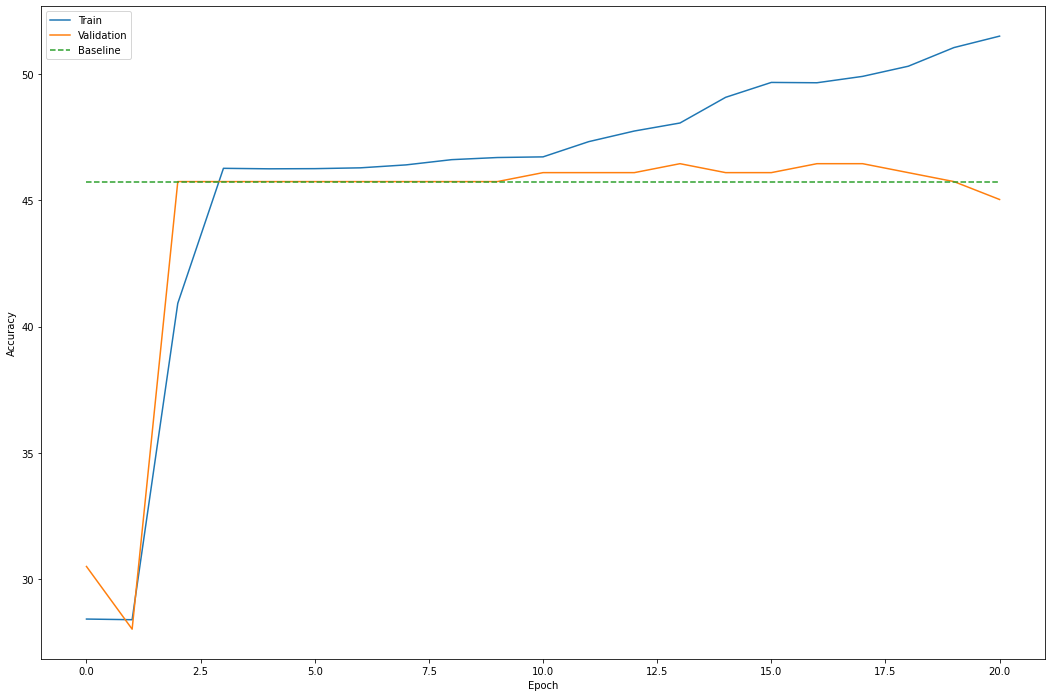

In [ ]:
y_train = np.array(train_accs)
y_dev = np.array(dev_accs)
x = np.arange(0, len(y_train))
plt.plot(x, y_train)
plt.plot(x, y_dev)
plt.plot(x, np.ones(x.shape[0]) * baseline_dev_acc, '--')
plt.legend(['Train', 'Validation', 'Baseline'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.gcf().set_size_inches(18, 12)
plt.gcf().set_facecolor('w')
fig.tight_layout()
plt.show()

### RPS

In [ ]:
pbc_model.load_state_dict(torch.load('player_bc.pth'))
pbc_model.eval()
rps_by_leagues = dict()
total_r = 0
total_size = 0
for test_data in test_groups:
  size = test_data.shape[0]
  total_size += size
  league_name = test_data['league'].values[0]
  home_test = torch.from_numpy(
    np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_test = torch.from_numpy(
      np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))
  league_rps = round(rps(pbc_model, home_test, away_test, y_test), 4)
  total_r += size * league_rps
  rps_by_leagues.update({league_name: league_rps})
print(rps_by_leagues)
print(total_r / total_size)

{'Belgium Jupiler League': 0.2304, 'England Premier League': 0.2267, 'France Ligue 1': 0.2256, 'Germany 1. Bundesliga': 0.227, 'Italy Serie A': 0.2137, 'Netherlands Eredivisie': 0.2351, 'Portugal Liga ZON Sagres': 0.2396, 'Scotland Premier League': 0.2447, 'Spain LIGA BBVA': 0.2229}
0.22786369764082814


# Player Cat Feed Forwards Modeling

## PlayerCatFeedForward Model

In [ ]:
class PlayerCatFeedForward(Module):
  def __init__(self, num_players, feed_forward_sizes, dropout_p=0.5):
    super(PlayerCatFeedForward, self).__init__()
    self.num_players = num_players
    self.dropout_p = dropout_p
    self.feed_forward_sizes = feed_forward_sizes
    self.one_hot = PlayerOneHot(self.num_players)
    self.decoder = CatFeedForward(self.num_players, self.feed_forward_sizes)

  def forward(self, home, away):
    home_encoded = self.one_hot(home)
    away_encoded = self.one_hot(away) 

    return self.decoder(home_encoded, away_encoded)

## Hyperparameters

In [ ]:
home_players = torch.from_numpy(home_player_labels)
away_players = torch.from_numpy(away_player_labels)
assert home_players.max() == away_players.max()
num_players = home_players.max() + 1

# embedding_size = 5
hidden_sizes = [2]
learning_rate = 1e-3
n_epochs = 10
every = 2
batch_size = 32

pcff_model = PlayerCatFeedForward(
    num_players,
    hidden_sizes,
    dropout_p=0.5
).double()

optimizer = torch.optim.Adam(pcff_model.parameters(), lr=learning_rate)
criterion = NLLLoss()
pcff_model

PlayerCatFeedForward(
  (one_hot): PlayerOneHot()
  (decoder): CatFeedForward(
    (fc_layers): ModuleList(
      (0): Linear(in_features=19026, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=3, bias=True)
    )
    (bn_layers): ModuleList(
      (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (regularizer): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (classifier): LogSoftmax(dim=-1)
  )
)

## Fitting

In [ ]:
for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(
      np.stack(train_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  home_train = home_train.reshape(-1, 11)
  away_train = torch.from_numpy(
      np.stack(train_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_train = away_train.reshape(-1, 11)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))

  home_dev = torch.from_numpy(
      np.stack(dev_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_dev = torch.from_numpy(
      np.stack(dev_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(
      np.stack(test_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_test = torch.from_numpy(
      np.stack(test_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      np.unique(train_set["league"].values).item(),
      pcff_model, 
      optimizer,
       criterion,
       n_epochs,
       every
  )

Fitting on the Belgium Jupiler League for 15 epochs
............................................................
Initial State
Train Acc%: 26.1905
Dev   Acc%: 33.0909
------------------------------------------------------------
Epoch 3
Avg Train Loss: 0.0314
Train Acc%:     48.4127
Dev   Acc%:     37.4545
------------------------------------------------------------
Epoch 6
Avg Train Loss: 0.0295
Train Acc%:     55.8730
Dev   Acc%:     37.0909
------------------------------------------------------------
Epoch 9
Avg Train Loss: 0.0300
Train Acc%:     56.9841
Dev   Acc%:     38.9091
------------------------------------------------------------
Epoch 12
Avg Train Loss: 0.0281
Train Acc%:     59.0476
Dev   Acc%:     40.3636
------------------------------------------------------------
Epoch 15
Avg Train Loss: 0.0298
Train Acc%:     60.9524
Dev   Acc%:     40.3636
Test Acc%: 46.3768
Fitting on the England Premier League for 15 epochs
............................................................

# DeepSet Blade Chest  Modeling

## DeepSetBladeChest Model

In [25]:
class DeepSetBladeChest(Module):
  def __init__(self, num_players, embedding_size, player_hidden_sizes, team_hidden_sizes, blade_chest_size, dropout=0.5):
    super(DeepSetBladeChest, self).__init__()
    self.num_players = num_players
    self.embedding_size = embedding_size
    self.player_hidden_sizes = player_hidden_sizes
    self.team_hidden_sizes = team_hidden_sizes
    self.blade_chest_size = blade_chest_size
    self.dropout=dropout

    self.player_embedder = Embedding(self.num_players, self.embedding_size)
    self.emb_bn = BatchNorm1d(self.embedding_size)

    self.player_fc = ModuleList([Conv1d(self.embedding_size, self.player_hidden_sizes[0], 1)] +\
    [Conv1d(size, self.player_hidden_sizes[index+1], 1) for index, size in enumerate(self.player_hidden_sizes[0:-1])])
    # self.player


    self.player_fc_bn = ModuleList([BatchNorm1d(size) for size in self.player_hidden_sizes])
    self.team_fc_list = [self.player_hidden_sizes[-1]] + list(team_hidden_sizes)
    self.team_fc = ModuleList(
        [
          Linear(size, self.team_fc_list[index + 1])
          for index, size in enumerate(self.team_fc_list[:-1])
        ]
    )
    self.team_fc_bn = ModuleList(
        [
          BatchNorm1d(size)
          for size in self.team_fc_list[1:]
        ]
    )

    self.decoder = BladeChest(self.team_fc_list[-1], self.blade_chest_size, self.dropout)
    self.regularizer = Dropout(p=self.dropout)
    self.fc_activation = ReLU()

  def _encode_team(self, team):
    embedding = self.player_embedder(team)
    embedding = self.emb_bn(embedding.moveaxis(-2, -1))
    # #dropout here?
    emnedding = self.regularizer(embedding)
    player_h = embedding
    for fc, bn in zip(self.player_fc, self.player_fc_bn):
      player_h = fc(player_h)
      player_h = bn(player_h)
      player_h = self.fc_activation(player_h)
      player_h = self.regularizer(player_h)
    
    team_h = player_h.sum(-1)

    for fc, bn in zip(self.team_fc, self.team_fc_bn):
      team_h = fc(team_h)
      team_h = bn(team_h)
      team_h = self.fc_activation(team_h)
      team_h = self.regularizer(team_h)

    return team_h

  def forward(self, home, away):
    home_encoded = self._encode_team(home)
    away_encoded = self._encode_team(away)
    return self.decoder(home_encoded, away_encoded)

## Hyperparameters

In [26]:
home_players = torch.from_numpy(home_player_labels)
away_players = torch.from_numpy(away_player_labels)
assert home_players.max() == away_players.max()
num_players = home_players.max() + 1

embedding_size = 2
player_hidden_sizes = [4, 6]
team_hidden_size = [8, 10]
blade_chest_size = 12
learning_rate = 1e-3
dropout = 0.5
n_epochs = 300
every = 25
batch_size = 32

dsbc_model = DeepSetBladeChest(
    num_players, 
    embedding_size, 
    player_hidden_sizes, 
    team_hidden_size, 
    blade_chest_size,
    dropout=dropout
)
optimizer = torch.optim.Adam(dsbc_model.parameters(), lr=learning_rate)
criterion = NLLLoss()
print(dsbc_model)
torchinfo.summary(dsbc_model)

DeepSetBladeChest(
  (player_embedder): Embedding(9513, 2)
  (emb_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (player_fc): ModuleList(
    (0): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
    (1): Conv1d(4, 6, kernel_size=(1,), stride=(1,))
  )
  (player_fc_bn): ModuleList(
    (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (team_fc): ModuleList(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=10, bias=True)
  )
  (team_fc_bn): ModuleList(
    (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): BladeChest(
    (chest_transform): Linear(in_features=10, out_features=12, bias=False)
    (chest_bn): BatchNorm1d(12, eps=1e-05, momen

Layer (type:depth-idx)                   Param #
DeepSetBladeChest                        --
├─Embedding: 1-1                         19,026
├─BatchNorm1d: 1-2                       4
├─ModuleList: 1-3                        --
│    └─Conv1d: 2-1                       12
│    └─Conv1d: 2-2                       30
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-3                  8
│    └─BatchNorm1d: 2-4                  12
├─ModuleList: 1-5                        --
│    └─Linear: 2-5                       56
│    └─Linear: 2-6                       90
├─ModuleList: 1-6                        --
│    └─BatchNorm1d: 2-7                  16
│    └─BatchNorm1d: 2-8                  20
├─BladeChest: 1-7                        --
│    └─Linear: 2-9                       120
│    └─BatchNorm1d: 2-10                 24
│    └─Linear: 2-11                      120
│    └─BatchNorm1d: 2-12                 24
│    └─Dropout: 2-13                     --
│    └─Tanh: 2-14      

## Fitting league-separate

In [ ]:
league_train_accs = []
league_dev_accs = []
league_test_accs = []
for train_set, dev_set, test_set in zip(train_groups[:], dev_groups[:], test_groups[:]):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(
      np.stack(train_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  # home_train = home_train.reshape(-1, 11)
  away_train = torch.from_numpy(
      np.stack(train_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  # away_train = away_train.reshape(-1, 11)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))
  # y_train = y_train.reshape(-1, batch_size)

  home_dev = torch.from_numpy(
      np.stack(dev_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_dev = torch.from_numpy(
      np.stack(dev_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(
      np.stack(test_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_test = torch.from_numpy(
      np.stack(test_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  train_accs, dev_accs, test_acc = main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      dsbc_model, 
      optimizer,
       criterion,
       n_epochs=800,
       every=25,
      league=np.unique(train_set["league"].values).item(),
  )
  league_train_accs.append(train_accs)
  league_dev_accs.append(dev_accs)
  league_test_accs.append(test_acc)

Fitting on the Belgium Jupiler League for 800 epochs
............................................................
Initial State
Train Acc%: 25.4707
Dev   Acc%: 23.0216
------------------------------------------------------------
Epoch 25
Avg Train Loss: 0.0357
Train Acc%:     46.2901
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 50
Avg Train Loss: 0.0359
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 75
Avg Train Loss: 0.0338
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 100
Avg Train Loss: 0.0348
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 125
Avg Train Loss: 0.0346
Train Acc%:     46.1794
Dev   Acc%:     49.6403
------------------------------------------------------------
Epoch 150
Avg Train Loss: 0.0332
Train Acc%:     46.1794
Dev   A

### Plots

In [ ]:
import matplotlib.pyplot as plt

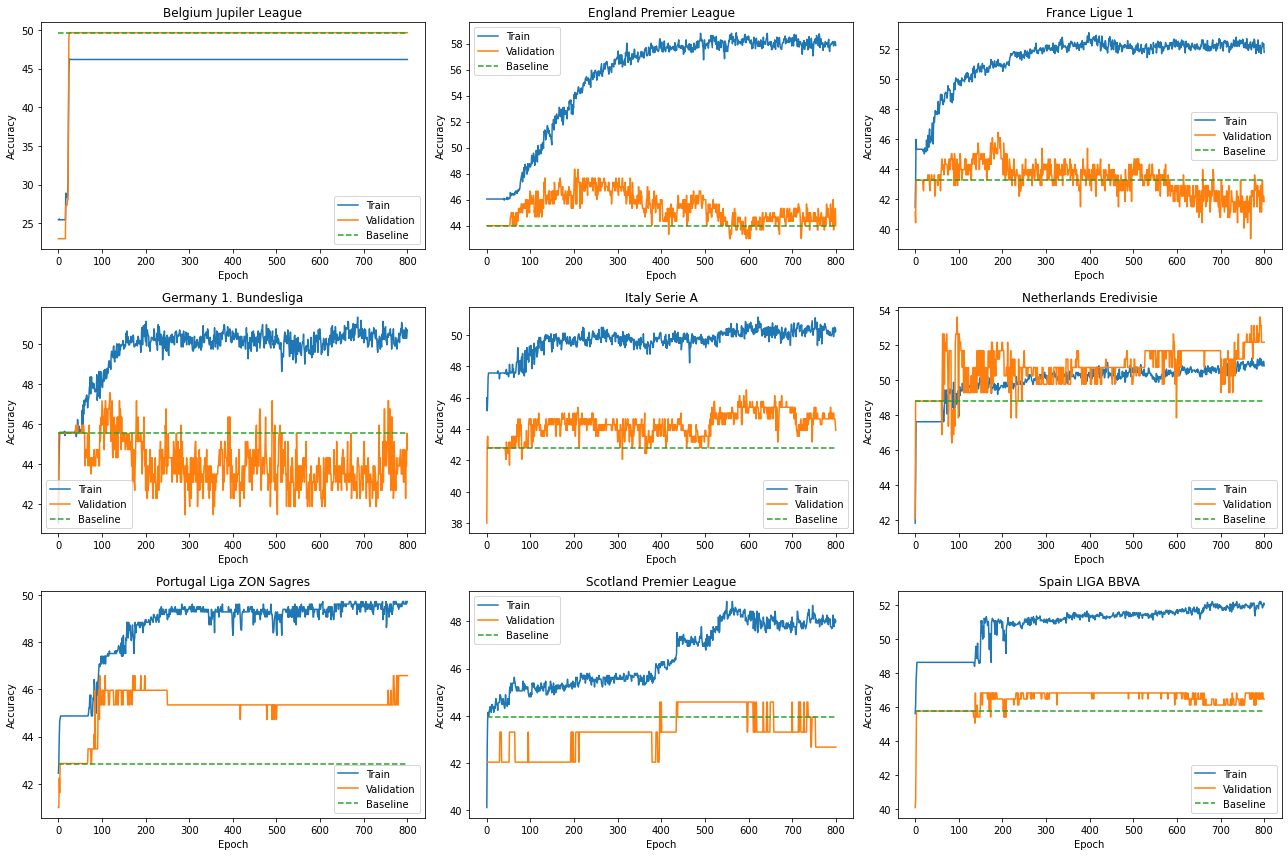

In [ ]:
fig, axs = plt.subplots(3, 3)
for train_acc, dev_acc, league_data, dev_data, ax in zip(league_train_accs, league_dev_accs, train_groups, dev_groups, axs.reshape(-1)):
  league = league_data['league'].values[0]
  baseline_dev_acc = (dev_data['result'].value_counts() / dev_data.shape[0])['win'] * 100
  y_train = np.array(train_acc)
  y_dev = np.array(dev_acc)
  x = np.arange(0, len(y_train))
  ax.plot(x, y_train)
  ax.plot(x, y_dev)
  ax.plot(x, np.ones(x.shape[0]) * baseline_dev_acc, '--')
  ax.legend(['Train', 'Validation', 'Baseline'])
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title(league)
plt.gcf().set_size_inches(18, 12)
plt.gcf().set_facecolor('w')
fig.tight_layout()
plt.show()

### Accuracy

In [ ]:
size = 0
sum = 0
for league_data, test_acc in zip(test_groups, league_test_accs):
  sample_size = league_data.shape[0]
  league = league_data['league'].values[0]
  sum += (sample_size * test_acc)
  size += sample_size
  print(league)
  print(f'Test Acc: {test_acc:.2f}% ')
  print('-' * 32)
print(f'Overall Test Acc: {sum / size:.2f}% ')

Belgium Jupiler League
Test Acc: 46.04% 
--------------------------------
England Premier League
Test Acc: 38.33% 
--------------------------------
France Ligue 1
Test Acc: 43.46% 
--------------------------------
Germany 1. Bundesliga
Test Acc: 44.72% 
--------------------------------
Italy Serie A
Test Acc: 45.96% 
--------------------------------
Netherlands Eredivisie
Test Acc: 45.93% 
--------------------------------
Portugal Liga ZON Sagres
Test Acc: 39.51% 
--------------------------------
Scotland Premier League
Test Acc: 42.41% 
--------------------------------
Spain LIGA BBVA
Test Acc: 50.35% 
--------------------------------
Overall Test Acc: 44.17% 


## Fitting whole

In [ ]:
#  for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
home_train = torch.from_numpy(
    np.stack(train_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
# home_train = home_train.reshape(-1, 11)
away_train = torch.from_numpy(
    np.stack(train_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
# away_train = away_train.reshape(-1, 11)
y_train = torch.from_numpy(train_data.loc[:, ['result_label']].values.reshape(-1))
# y_train = y_train.reshape(-1, batch_size)

home_dev = torch.from_numpy(
    np.stack(dev_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
away_dev = torch.from_numpy(
    np.stack(dev_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
y_dev = torch.from_numpy(dev_data.loc[:, ['result_label']].values.reshape(-1))

home_test = torch.from_numpy(
    np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
away_test = torch.from_numpy(
    np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
).long()
y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

train_accs, dev_accs, test_accs = main(
    (home_train, away_train, y_train),
    batch_size,
    (home_dev, away_dev, y_dev),
    (home_test, away_test, y_test),
    dsbc_model, 
    optimizer,
    criterion,
    n_epochs=170,
    every=5
)

Initial State
Train Acc%: 25.3419
Dev   Acc%: 24.9634
------------------------------------------------------------
Epoch 5
Avg Train Loss: 0.0331
Train Acc%:     46.2441
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 10
Avg Train Loss: 0.0332
Train Acc%:     46.2441
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 15
Avg Train Loss: 0.0331
Train Acc%:     46.2441
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 20
Avg Train Loss: 0.0338
Train Acc%:     46.2441
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 25
Avg Train Loss: 0.0332
Train Acc%:     46.2441
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 30
Avg Train Loss: 0.0330
Train Acc%:     46.2441
Dev   Acc%:     44.9438
------------------------------------------------------------
Epoch 35
Avg Train Loss: 0.0332
Train Ac

In [ ]:
baseline_dev_acc = (dev_data['result'].value_counts() / dev_data.shape[0])['win'] * 100

### Plots

In [ ]:
import matplotlib.pyplot as plt

NameError: ignored

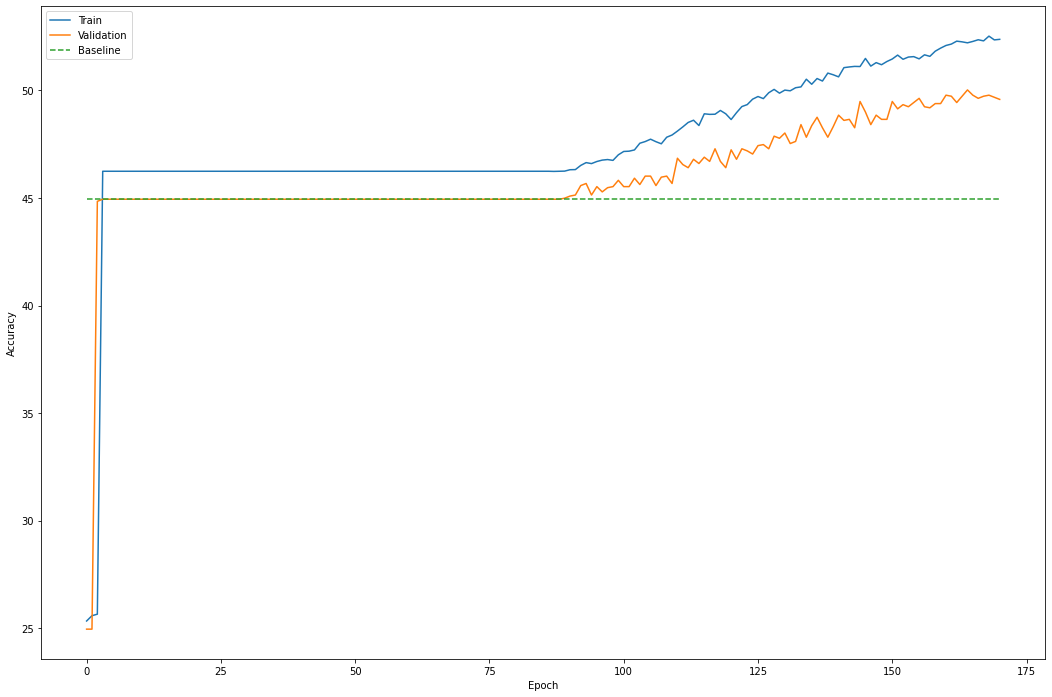

In [ ]:
y_train = np.array(train_accs)
y_dev = np.array(dev_accs)
x = np.arange(0, len(y_train))
plt.plot(x, y_train)
plt.plot(x, y_dev)
plt.plot(x, np.ones(x.shape[0]) * baseline_dev_acc, '--')
plt.legend(['Train', 'Validation', 'Baseline'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.gcf().set_size_inches(18, 12)
plt.gcf().set_facecolor('w')
fig.tight_layout()
plt.show()

### RPS

In [ ]:
dsbc_model.load_state_dict(torch.load('deep_set_bc.pth'))
dsbc_model.eval()
rps_by_leagues = dict()
total_r = 0
total_size = 0
for test_data in test_groups:
  league_name = test_data['league'].values[0]
  size = test_data.shape[0]
  total_size += size
  home_test = torch.from_numpy(
    np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_test = torch.from_numpy(
      np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))
  league_rps = round(rps(dsbc_model, home_test, away_test, y_test), 4)
  total_r += size * league_rps
  rps_by_leagues.update({league_name: league_rps})
print(rps_by_leagues)
print(total_r / total_size)

{'Belgium Jupiler League': 0.2275, 'England Premier League': 0.2292, 'France Ligue 1': 0.2128, 'Germany 1. Bundesliga': 0.2154, 'Italy Serie A': 0.208, 'Netherlands Eredivisie': 0.2274, 'Portugal Liga ZON Sagres': 0.2175, 'Scotland Premier League': 0.2319, 'Spain LIGA BBVA': 0.1984}
0.21719224843524312


# DeepSet Blade Cat Feed Forward  Modeling

## DeepSetCatFeedForward Model

In [ ]:
class DeepSetCatFeedForward(Module):
  def __init__(self, num_players, embedding_size, player_hidden_size, team_hidden_sizes, feed_forward_sizes, dropout=0.5):
    super(DeepSetCatFeedForward, self).__init__()
    self.num_players = num_players
    self.embedding_size = embedding_size
    self.player_hidden_size = player_hidden_size
    self.team_hidden_sizes = team_hidden_sizes
    self.feed_forward_sizes = feed_forward_sizes
    self.dropout=dropout

    self.player_embedder = Embedding(self.num_players, self.embedding_size)
    self.emb_bn = BatchNorm1d(self.embedding_size)

    self.player_fc = Conv1d(self.embedding_size, self.player_hidden_size, 1)
    self.player_fc_bn = BatchNorm1d(self.player_hidden_size)
    self.team_fc_list = [self.player_hidden_size] + list(team_hidden_sizes)
    self.team_fc = ModuleList(
        [
          Linear(size, self.team_fc_list[index + 1])
          for index, size in enumerate(self.team_fc_list[:-1])
        ]
    )
    self.team_fc_bn = ModuleList(
        [
          BatchNorm1d(size)
          for size in self.team_fc_list[1:]
        ]
    )

    self.decoder = CatFeedForward(self.team_fc_list[-1], self.feed_forward_sizes)
    self.regularizer = Dropout(p=self.dropout)
    self.fc_activation = ReLU()

  def _encode_team(self, team):
    embedding = self.player_embedder(team)
    embedding = self.emb_bn(embedding.moveaxis(-2, -1))
    # #dropout here?
    emnedding = self.regularizer(embedding)

    player_h = self.player_fc(embedding)
    player_h = self.player_fc_bn(player_h)
    player_h = self.fc_activation(player_h)
    player_h = self.regularizer(player_h)
    team_h = player_h.sum(-1)

    for fc, bn in zip(self.team_fc, self.team_fc_bn):
      team_h = fc(team_h)
      team_h = bn(team_h)
      team_h = self.fc_activation(team_h)
      team_h = self.regularizer(team_h)

    return team_h

  def forward(self, home, away):
    home_encoded = self._encode_team(home)
    away_encoded = self._encode_team(away)
    return self.decoder(home_encoded, away_encoded)

## Hyperparameters

In [ ]:
home_players = torch.from_numpy(home_player_labels)
away_players = torch.from_numpy(away_player_labels)
assert home_players.max() == away_players.max()
num_players = home_players.max() + 1

embedding_size = 4
player_hidden_size = 12
team_hidden_size = [14, 16]
hidden_sizes = [16]
learning_rate = 1e-3
dropout = 0.5
n_epochs = 75
every = 15
batch_size = 32

dscff_model = DeepSetCatFeedForward(
    num_players, 
    embedding_size, 
    player_hidden_size, 
    team_hidden_size, 
    hidden_sizes,
    dropout=dropout
)
optimizer = torch.optim.Adam(dscff_model.parameters(), lr=learning_rate)
criterion = NLLLoss()
dscff_model

DeepSetCatFeedForward(
  (player_embedder): Embedding(9513, 4)
  (emb_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (player_fc): Conv1d(4, 12, kernel_size=(1,), stride=(1,))
  (player_fc_bn): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (team_fc): ModuleList(
    (0): Linear(in_features=12, out_features=14, bias=True)
    (1): Linear(in_features=14, out_features=16, bias=True)
  )
  (team_fc_bn): ModuleList(
    (0): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): CatFeedForward(
    (fc_layers): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=3, bias=True)
    )
    (bn_layers): ModuleList(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (regularizer

## Fitting

In [ ]:
for train_set, dev_set, test_set in zip(train_groups, dev_groups, test_groups):
  # batch_size = train_set.shape[0]
  home_train = torch.from_numpy(
      np.stack(train_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  home_train = home_train.reshape(-1, 11)
  away_train = torch.from_numpy(
      np.stack(train_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_train = away_train.reshape(-1, 11)
  y_train = torch.from_numpy(train_set.loc[:, ['result_label']].values.reshape(-1))
  # y_train = y_train.reshape(-1, batch_size)

  home_dev = torch.from_numpy(
      np.stack(dev_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_dev = torch.from_numpy(
      np.stack(dev_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_dev = torch.from_numpy(dev_set.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(
      np.stack(test_set['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  away_test = torch.from_numpy(
      np.stack(test_set['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
  y_test = torch.from_numpy(test_set.loc[:, ['result_label']].values.reshape(-1))

  main(
      (home_train, away_train, y_train),
       batch_size,
      (home_dev, away_dev, y_dev),
      (home_test, away_test, y_test),
      np.unique(train_set["league"].values).item(),
      dscff_model, 
      optimizer,
       criterion,
       n_epochs,
       every
  )

Fitting on the Belgium Jupiler League for 75 epochs
............................................................
Initial State
Train Acc%: 47.9365
Dev   Acc%: 42.1818
------------------------------------------------------------
Epoch 15
Avg Train Loss: 0.0311
Train Acc%:     48.0952
Dev   Acc%:     42.1818
------------------------------------------------------------
Epoch 30
Avg Train Loss: 0.0336
Train Acc%:     48.0952
Dev   Acc%:     42.1818
------------------------------------------------------------
Epoch 45
Avg Train Loss: 0.0355
Train Acc%:     48.0952
Dev   Acc%:     42.1818
------------------------------------------------------------
Epoch 60
Avg Train Loss: 0.0332
Train Acc%:     48.0952
Dev   Acc%:     42.1818
------------------------------------------------------------
Epoch 75
Avg Train Loss: 0.0347
Train Acc%:     48.0952
Dev   Acc%:     42.1818
Test Acc%: 47.4638
Fitting on the England Premier League for 75 epochs
.........................................................

# Test

In [ ]:
len(test_groups)

9

In [ ]:
tbc_model.load_state_dict(torch.load('team_bc.pth'))
dsbc_model.load_state_dict(torch.load('deep_set_bc.pth'))
pbc_model.load_state_dict(torch.load('player_bc.pth'))
tbc_model.eval()
dsbc_model.eval()
pbc_model.eval()

test_data = pd.concat(test_groups)

tbc_home_test = torch.from_numpy(test_data.loc[:, ['home_team_label']].values.reshape(-1))
tbc_away_test = torch.from_numpy(test_data.loc[:, ['away_team_label']].values.reshape(-1))
tbc_y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

pds_home_test = torch.from_numpy(
      np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
pds_away_test = torch.from_numpy(
      np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
pds_y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

print('Team Blade Chest: ')
print('RPS:', rps(tbc_model, tbc_home_test, tbc_away_test, tbc_y_test))
c, a = evaluate(tbc_model, tbc_home_test, tbc_away_test, tbc_y_test)
print('Acc%:', c / a)
print('-' * 32)
print('Player Blade Chest: ')
print(rps(pbc_model, pds_home_test, pds_away_test, pds_y_test))
c, a = evaluate(pbc_model, pds_home_test, pds_away_test, pds_y_test)

print('Acc%:', c / a)
print('-' * 32)
print('Deep Set Blade Chest: ')
print('RPS:', rps(dsbc_model, pds_home_test, pds_away_test, pds_y_test))
c, a = evaluate(dsbc_model, pds_home_test, pds_away_test, pds_y_test)
print('Acc%:', c / a)

In [ ]:
# tbc_model.load_state_dict(torch.load('team_bc.pth'))
bahrami = dict()
for league_data in test_groups:
  league = league_data['league'].values[0]
  # home_test = torch.from_numpy(
  #     np.stack(league_data['home_team_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  # ).long()
  # away_test = torch.from_numpy(
  #     np.stack(league_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  # ).long()
  # y_test = torch.from_numpy(league_data.loc[:, ['result_label']].values.reshape(-1))

  home_test = torch.from_numpy(league_data.loc[:, ['home_team_label']].values.reshape(-1))
  away_test = torch.from_numpy(league_data.loc[:, ['away_team_label']].values.reshape(-1))
  y_test = torch.from_numpy(league_data.loc[:, ['result_label']].values.reshape(-1))

  #################
  # pbc_model.eval()
  c, a = evaluate(tbc_model, home_test, away_test, y_test)
  bahrami.update({league: (c / a * 100)})
  #################
print(bahrami)

# Johnstone 

In [ ]:
tbc_model.load_state_dict(torch.load('team_bc.pth'))
dsbc_model.load_state_dict(torch.load('deep_set_bc.pth'))
pbc_model.load_state_dict(torch.load('player_bc.pth'))
tbc_model.eval()
dsbc_model.eval()
pbc_model.eval()


In [76]:
dev_data = pd.concat(dev_groups)
test_data = pd.concat(test_groups)

In [77]:
tbc_home_test = torch.from_numpy(test_data.loc[:, ['home_team_label']].values.reshape(-1))
tbc_away_test = torch.from_numpy(test_data.loc[:, ['away_team_label']].values.reshape(-1))
tbc_y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

pds_home_test = torch.from_numpy(
      np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
pds_away_test = torch.from_numpy(
      np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
pds_y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

pbc_home_test = torch.from_numpy(
      np.stack(test_data['home_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
pbc_away_test = torch.from_numpy(
      np.stack(test_data['away_lineup_label'].apply(lambda lineup: lineup.split(' - '))).astype(np.int16)
  ).long()
pbc_y_test = torch.from_numpy(test_data.loc[:, ['result_label']].values.reshape(-1))

with torch.no_grad() as _:
  logits_tbc = torch.exp(tbc_model(tbc_home_test, tbc_away_test))
  logits_dsbc = torch.exp(dsbc_model(pds_home_test, pds_away_test))
  logits_pbc = torch.exp(pbc_model(pbc_home_test, pbc_away_test))

labels = F.one_hot(
    torch.from_numpy(test_data['result_label'].values), 
    3
)

In [40]:
from itertools import groupby

In [100]:
def johnstone(labels: torch.Tensor, odds: torch.Tensor, logits: torch.Tensor) -> float:
  _ = (labels * odds * logits).sum(-1)

  return torch.log(_)

In [102]:
odd_names = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA']
for bookmaker, _odds in groupby(odd_names, key=lambda value: value[:-1]):
  odd_columns = list(_odds)
  odds = torch.from_numpy(test_data[odd_columns].values)
  # print(
  #     (odds * labels * logits_tbc).sum(-1)
  # )
  # break
  scores_tbc = johnstone(labels, odds, logits_tbc)
  scores_pbc = johnstone(labels, odds, logits_pbc)
  scores_dsbc = johnstone(labels, odds, logits_dsbc)
  
  print(f'Team Blade Chest:     {scores_tbc.mean(): .3f}  on {bookmaker}')
  print(f'Player Blade Chest:   {scores_pbc.mean():.3f}  on {bookmaker}')
  print(f'Deep Set Blade Chest: {scores_dsbc.mean(): .3f} on {bookmaker}')


Team Blade Chest:      0.274  on B365
Player Blade Chest:   0.308  on B365
Deep Set Blade Chest:  0.339 on B365
Team Blade Chest:      0.240  on BW
Player Blade Chest:   0.274  on BW
Deep Set Blade Chest:  0.305 on BW
Team Blade Chest:      0.203  on IW
Player Blade Chest:   0.237  on IW
Deep Set Blade Chest:  0.268 on IW
Team Blade Chest:      0.256  on LB
Player Blade Chest:   0.290  on LB
Deep Set Blade Chest:  0.320 on LB
